In [0]:
# Seed value
seed_value= 0
 
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
 
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
 
# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# %tensorflow_version 1.x

In [0]:
import pandas as pd
import cv2 as cv2
import datetime
import math
import time
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **GET DATASET**

In [0]:
# Load the data from the csv file.
# path = path to your csv file
path_original = '/content/drive/My Drive/datasets/facial-expression/fer2013/fer2013_bias_analysis.csv'
complete_fer_dataset = pd.read_csv(path_original)

In [0]:
complete_fer_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44149 entries, 0 to 44148
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  44149 non-null  int64 
 1   pixels   44149 non-null  object
 2   usage    44149 non-null  object
 3   age      44149 non-null  object
 4   gender   44149 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [0]:
# How many images to process
batch_size = 10000

In [0]:
# Get first batch_size rows from dataframe
fer_dataset = complete_fer_dataset.head(batch_size)

In [0]:
# Delete first batch_size rows and save the rest content of the file 
indexes_for_delete = np.arange(batch_size)
complete_fer_dataset = complete_fer_dataset.drop(complete_fer_dataset.index[indexes_for_delete],axis = 0)
complete_fer_dataset.reset_index()
complete_fer_dataset.to_csv(path_original,index=False)

IndexError: ignored

# **PREPROCESARE**

In [0]:
# The function for getting the pixels as a list 
# input_set: dataset 
# @return: an array of flattened images
def getPixels(input_set):
  pixels = input_set['pixels'].tolist()
  new_pixels = []
  for pixel_sequence in pixels:
    image = [int(pixel) for pixel in pixel_sequence.split(' ')]
    new_pixels.append(image)
  return np.asarray(new_pixels, dtype='uint8')  

# The function for reshpping the dataset
# cutsize: if True the image will be cutted
# input_set: dataset with only pixels (# the return of the getPixels(input_set))
def reshapeDataset(input_set):
  new_input_set = []
  for image in input_set:
    # reshape the image in (48, 48) shape
    image = image.reshape((48, 48))

    # add new axis for being in (48, 48, 1) shape
    image = image[:, :, np.newaxis]

    # reshape in (48, 48, 3) shape by concatenating 3 times the image
    image = np.concatenate((image, image, image), axis=2)
    new_input_set.append(image)
  return np.asarray(new_input_set, dtype='uint8')

# This function is going to help with normalizing and reshapping a set
def normalize_reshape_set(input_set):
  images = getPixels(input_set)
  print('Done with pixels of images')

  reshapped_images = reshapeDataset(images)
  print('Done reshaping the images')

  return reshapped_images

In [0]:
# We want to preparing the data set for normalizing part

# 1. Split the data frame for training, data for validation,data for testing
data_for_training = fer_dataset[fer_dataset['Usage'] == 'Training']

data_for_validation = fer_dataset[fer_dataset['Usage'] == 'PublicTest']
data_for_testing = fer_dataset[fer_dataset['Usage'] == 'PrivateTest']

# Print the shape of the sets
print('Train shape = ',data_for_training.shape)
print('Validation shape = ',data_for_validation.shape)
print('Test shape = ',data_for_testing.shape)

Train shape =  (3125, 3)
Validation shape =  (512, 3)
Test shape =  (512, 3)


In [0]:
# 2. Drop the column Usage from train, validation and test sets
data_for_training = data_for_training.drop(['Usage'],axis=1)
data_for_validation = data_for_validation.drop(['Usage'],axis=1)
data_for_testing = data_for_testing.drop(['Usage'],axis=1)

In [0]:
# 3. Split the data in X and y format; 
#    X stands for the column 'pixels' from original dataframe and y stands for column 'emotion' from original dataset
#    The partitioning will be: X_train, y_train, X_validation, y_validation, X_test, y_test

X_train = normalize_reshape_set(data_for_training)
X_val = normalize_reshape_set(data_for_validation)
X_test = normalize_reshape_set(data_for_testing)

y_train = np.asarray(data_for_training['emotion'], dtype='int32')
y_val = np.asarray(data_for_validation['emotion'], dtype='int32')
y_test = np.asarray(data_for_testing['emotion'], dtype='int32')

Done with pixels of images
Done reshaping the images
Done with pixels of images
Done reshaping the images
Done with pixels of images
Done reshaping the images


In [0]:
# Let's check the shape of every set
print('X_train = ',X_train.shape)
print('X_val = ', X_val.shape)
print('X_test = ', X_test.shape)

X_train =  (3125, 48, 48, 3)
X_val =  (512, 48, 48, 3)
X_test =  (512, 48, 48, 3)


# **MAKE PREDICTIONS**

In [0]:
# Function for writing to CSV
def writeToCSV(path, x, y, ageNet, genderNet, usage):
  for i in range(len(x)):
    if i % 1000 == 0: print("DONE WITH " + str(i) + "IMAGES!")
    # get info about every image
    image = x[i]
    label = y[i]
    usg = usage

    # resize the image for being in shape as the input (227, 227)
    resized = cv2.resize(image, (227, 227), interpolation = cv2.INTER_AREA)
    blob=cv2.dnn.blobFromImage(resized, 1.0, (227,227), MODEL_MEAN_VALUES, swapRB=False)

    # Get the gender predicition
    genderNet.setInput(blob)
    genderPreds=genderNet.forward()
    gender=genderList[genderPreds[0].argmax()]

    # Get the age prediction
    ageNet.setInput(blob)
    agePreds=ageNet.forward()
    age=ageList[agePreds[0].argmax()]

    # Flattening image
    image = image[:,:,-1]
    image = image.reshape(image.shape[0]*image.shape[1])

    # Transform the pixels into string
    string_image =' '.join([str(int(pixel)) for pixel in image])

    # Write to csv the image with the label 
    with open(path, mode='a') as images_file:
      images_writer = csv.writer(images_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
      images_writer.writerow([label, string_image, usage,age,gender])


In [0]:
path ='/content/drive/My Drive/datasets/facial-expression/fer2013/fer2013_bias_analysis.csv'
header = ['emotion','pixels','usage','age','gender','race']
ageProto="/content/drive/My Drive/FaceX/gad/age_deploy.prototxt"
ageModel="/content/drive/My Drive/FaceX/gad/age_net.caffemodel"
genderProto="/content/drive/My Drive/FaceX/gad/gender_deploy.prototxt"
genderModel="/content/drive/My Drive/FaceX/gad/gender_net.caffemodel"

MODEL_MEAN_VALUES=(78.4263377603, 87.7689143744, 114.895847746)
ageList=['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList=['Male','Female']

ageNet=cv2.dnn.readNet(ageModel,ageProto)
genderNet=cv2.dnn.readNet(genderModel,genderProto)

In [0]:
# Write to csv images from Trainig set
start = time.time()

writeToCSV(path, X_train, y_train, ageNet, genderNet,'Training')

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

DONE WITH 0IMAGES!
DONE WITH 1000IMAGES!
DONE WITH 2000IMAGES!
DONE WITH 3000IMAGES!
00:05:13.03


In [0]:
# Write to csv images from Validation set
start = time.time()

writeToCSV(path, X_val, y_val, ageNet, genderNet, 'PublicTest')

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

DONE WITH 0IMAGES!
00:00:51.23


In [0]:
# Write to csv images from Testing set
start = time.time()

writeToCSV(path, X_test, y_test, ageNet, genderNet, 'PrivateTest')

# 
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

DONE WITH 0IMAGES!
00:00:51.33


In [0]:
# ageProto="/content/drive/My Drive/FaceX/gad/age_deploy.prototxt"
# ageModel="/content/drive/My Drive/FaceX/gad/age_net.caffemodel"
# genderProto="/content/drive/My Drive/FaceX/gad/gender_deploy.prototxt"
# genderModel="/content/drive/My Drive/FaceX/gad/gender_net.caffemodel"

# MODEL_MEAN_VALUES=(78.4263377603, 87.7689143744, 114.895847746)
# ageList=['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
# genderList=['Male','Female']

# ageNet=cv2.dnn.readNet(ageModel,ageProto)
# genderNet=cv2.dnn.readNet(genderModel,genderProto)

# blob=cv2.dnn.blobFromImage(resized, 1.0, (227,227), MODEL_MEAN_VALUES, swapRB=False)
# genderNet.setInput(blob)
# genderPreds=genderNet.forward()
# gender=genderList[genderPreds[0].argmax()]
# print(f'Gender: {gender}')

# ageNet.setInput(blob)
# agePreds=ageNet.forward()
# age=ageList[agePreds[0].argmax()]
# print(f'Age: {age[1:-1]} years')

# **GET DISTRIBUTIONS**

In [0]:
path_to_bias_dataset = '/content/drive/My Drive/datasets/facial-expression/fer2013/fer2013_bias_analysis.csv'
fer_dataset = pd.read_csv(path_to_bias_dataset)

In [0]:
fer_dataset.describe()

,emotion
count,44149.000000
mean,3.065483
std,1.910660
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [0]:
fer_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44149 entries, 0 to 44148
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  44149 non-null  int64 
 1   pixels   44149 non-null  object
 2   usage    44149 non-null  object
 3   age      44149 non-null  object
 4   gender   44149 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


Text(0.5, 1.0, 'Overall age distribution')

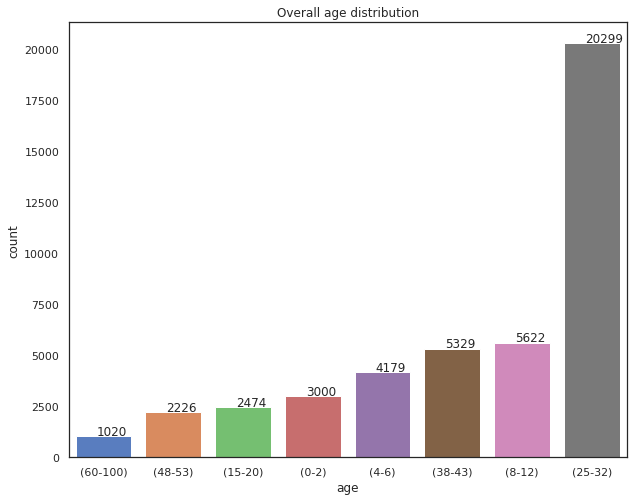

In [0]:
sns.set(style="white", palette="muted", color_codes=True)

# Set up the matplotlib figure
plt.figure(figsize = (10,8))
ax = sns.countplot(fer_dataset['age'], order = fer_dataset['age'].value_counts(ascending=True).index)
for p in ax.patches: 
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+50))
plt.title('Overall age distribution')


Text(0.5, 1.0, 'Overall gender distribution')

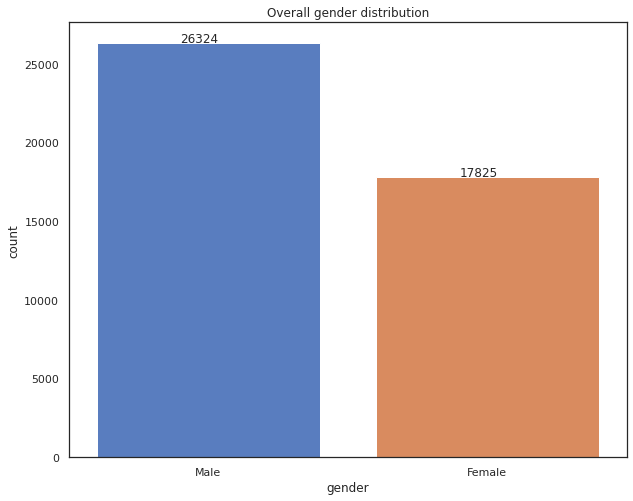

In [0]:
sns.set(style="white", palette="muted", color_codes=True)

# Set up the matplotlib figure
plt.figure(figsize = (10,8))
ax = sns.countplot(fer_dataset['gender'], label='Count')
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+50))
plt.title('Overall gender distribution')


In [0]:
# Get the distribution of a class regarding gender and age
def getDistribution_of_class(mask, title, second_parameter, desired_class):
  class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
  sns.set(style="white", palette="muted", color_codes=True)
  plt.figure(figsize = (10,8))
  if(second_parameter == 'age'):
    ax = sns.countplot(fer_dataset[mask][second_parameter], order = fer_dataset[mask][second_parameter].value_counts(ascending=True).index, color='g')
    for p in ax.patches: 
            ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+50))
  else:
    ax = sns.countplot(fer_dataset[mask][second_parameter], label='Count')
    for p in ax.patches:
            ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+50))
  plt.title(title + class_names[desired_class])

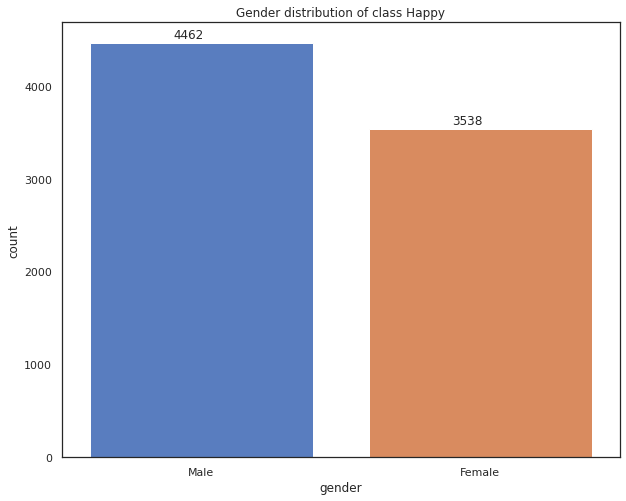

In [0]:
desired_class = 3
mask = (fer_dataset['emotion'] == desired_class) 
getDistribution_of_class(mask, 'Gender distribution of class ', 'gender',desired_class)

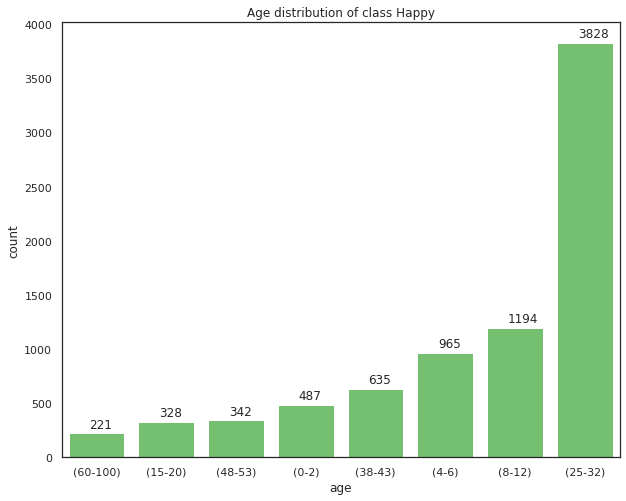

In [0]:
desired_class = 3
mask = (fer_dataset['emotion'] == desired_class) 
getDistribution_of_class(mask, 'Age distribution of class ', 'age', desired_class)

In [0]:
def getGrouppedDistribution_of_class(df, mask, title, desired_class):
  class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
  sns.set(style="white", palette="deep", color_codes=True)
  plt.figure(figsize = (20,8))

  ax = sns.countplot(x=df[mask]['age'], hue="gender", data=df,order = df[mask]['age'].value_counts(ascending=False).index);
  for p in ax.patches:
          ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+10))
  plt.title(title + class_names[desired_class] + ' class')
  plt.savefig("/content/drive/My Drive/FaceX/bias_plots/distribution_class_"+class_names[desired_class]+".png")

In [0]:
for i in range(7):
  desired_class = i
  mask = (fer_dataset['emotion'] == desired_class) 
  getGrouppedDistribution_of_class(fer_dataset,mask,'Age and Gender distribution for ', desired_class)  

# **MAKE PREDICTIONS FOR RACE**

In [0]:
# Seed value
seed_value= 0
 
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
 
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
 
# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
 
# 5. Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [0]:
import seaborn as sns
import pandas as pd
import cv2 as cv2
import matplotlib.pyplot as plt


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
race_only = '/content/drive/My Drive/datasets/facial-expression/fer2013/fer2013_bias_analysis_race_only.csv'
race_only_fer_dataset = pd.read_csv(race_only)

In [0]:
without_race = '/content/drive/My Drive/datasets/facial-expression/fer2013/fer2013_bias_analysis.csv'
without_race_fer_dataset = pd.read_csv(without_race)

In [0]:
race_only_fer_dataset

,emotion,pixels,usage,race
0,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,Training,3
1,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,Training,0
2,2,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,Training,3
3,4,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,Training,3
4,6,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,Training,5
...,...,...,...,...
44144,5,1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,PrivateTest,5
44145,5,0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,PrivateTest,3
44146,5,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,PrivateTest,3
44147,5,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,PrivateTest,3


In [0]:
without_race_fer_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44149 entries, 0 to 44148
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  44149 non-null  int64 
 1   pixels   44149 non-null  object
 2   usage    44149 non-null  object
 3   age      44149 non-null  object
 4   gender   44149 non-null  object
 5   race     44149 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


In [0]:
race_only_fer_dataset = race_only_fer_dataset.drop(['emotion','pixels','usage'],axis=1)

In [0]:
concatenated_dataset = pd.concat([without_race_fer_dataset, race_only_fer_dataset], axis=1)

In [0]:
concatenated_dataset.to_csv('/content/drive/My Drive/datasets/facial-expression/fer2013/fer2013_gender_age_race.csv', index=False)

Text(0.5, 1.0, 'Data partitioning')

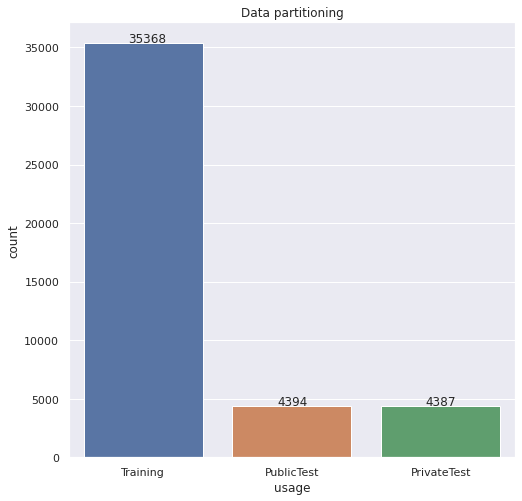

In [0]:
# In order to check how data is partitioned we're going to do a counter plot
# The PublicTest will be used for validation
# The PrivateTest will be used for testing
plt.figure(figsize = (8,8))
sns.set(style="darkgrid")
ax = sns.countplot(complete_fer_dataset['usage'], label='Count')
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+50))
plt.title('Data partitioning')

In [0]:
# How many images to process
batch_size = 4149
# Get first batch_size rows from dataframe
fer_dataset = complete_fer_dataset.head(batch_size)
# Delete first batch_size rows and save the rest content of the file 
indexes_for_delete = np.arange(batch_size)
complete_fer_dataset = complete_fer_dataset.drop(complete_fer_dataset.index[indexes_for_delete],axis = 0)
complete_fer_dataset.reset_index()
complete_fer_dataset.to_csv(path_original,index=False)

In [0]:
# Function for normalizing the dataset
# input_set: dataset 
# scaler: the scaler for normalize
# @return: dataset with normalized data
def normalizeSet(input_set, scaler):
  x = scaler.fit_transform(input_set)
  return x

# The function for getting the pixels as a list 
# input_set: dataset 
# @return: an array of flattened images
def getPixels(input_set):
  pixels = input_set['pixels'].tolist()
  new_pixels = []
  for pixel_sequence in pixels:
    image = [int(pixel) for pixel in pixel_sequence.split(' ')]
    new_pixels.append(image)
  return np.asarray(new_pixels, dtype='float32')  

# The function for reshpping the dataset
# cutsize: if True the image will be cutted
# input_set: dataset with only pixels (# the return of the getPixels(input_set))
def reshapeDataset(input_set, cutsize=False):
  new_input_set = []
  for image in input_set:
    # reshape the image in (48, 48) shape
    image = image.reshape((48, 48))
    
    # # resize the image in (44, 44) shape
    # if cutsize:
    #   image = cv2.resize(image,(44, 44))

    # add new axis for being in (48, 48, 1) shape
    image = image[:, :, np.newaxis]

    # reshape in (48, 48, 3) shape by concatenating 3 times the image
    image = np.concatenate((image, image, image), axis=2)
    new_input_set.append(image)
  return np.asarray(new_input_set, dtype='float32')

# This function is going to help with normalizing and reshapping a set
def normalize_reshape_set(input_set, scaler, cutsize):
  images = getPixels(input_set)
  print('Done with pixels of images')

  images = normalizeSet(images,scaler)
  print('Done normalizing the images')

  reshapped_images = reshapeDataset(images,cutsize)
  print('Done reshaping the images')

  return reshapped_images

In [0]:
# We want to preparing the data set for normalizing part

# 1. Split the data frame for training, data for validation,data for testing
data_for_training = fer_dataset[fer_dataset['usage'] == 'Training']

data_for_validation = fer_dataset[fer_dataset['usage'] == 'PublicTest']
data_for_testing = fer_dataset[fer_dataset['usage'] == 'PrivateTest']

# Print the shape of the sets
print('Train shape = ',data_for_training.shape)
print('Validation shape = ',data_for_validation.shape)
print('Test shape = ',data_for_testing.shape)

Train shape =  (3125, 5)
Validation shape =  (512, 5)
Test shape =  (512, 5)


In [0]:
# 2. Drop the column usage, age, gender from train, validation and test sets
data_for_training = data_for_training.drop(['usage'],axis=1)
data_for_validation = data_for_validation.drop(['usage'],axis=1)
data_for_testing = data_for_testing.drop(['usage'],axis=1)

data_for_training = data_for_training.drop(['age'],axis=1)
data_for_validation = data_for_validation.drop(['age'],axis=1)
data_for_testing = data_for_testing.drop(['age'],axis=1)

data_for_training = data_for_training.drop(['gender'],axis=1)
data_for_validation = data_for_validation.drop(['gender'],axis=1)
data_for_testing = data_for_testing.drop(['gender'],axis=1)

In [0]:
# 3. Split the data in X and y format; 
#    X stands for the column 'pixels' from original dataframe and y stands for column 'emotion' from original dataset
#    The partitioning will be: X_train, y_train, X_validation, y_validation, X_test, y_test

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train = normalize_reshape_set(data_for_training, scaler, cutsize = False)
X_val = normalize_reshape_set(data_for_validation, scaler, cutsize = True)
X_test = normalize_reshape_set(data_for_testing, scaler, cutsize = True)

y_train = np.asarray(data_for_training['emotion'], dtype='int32')
y_val = np.asarray(data_for_validation['emotion'], dtype='int32')
y_test = np.asarray(data_for_testing['emotion'], dtype='int32')

Done with pixels of images
Done normalizing the images
Done reshaping the images
Done with pixels of images
Done normalizing the images
Done reshaping the images
Done with pixels of images
Done normalizing the images
Done reshaping the images


In [0]:
# Let's check the shape of every set
print('X_train = ',X_train.shape)
print('X_val = ', X_val.shape)
print('X_test = ', X_test.shape)

X_train =  (3125, 48, 48, 3)
X_val =  (512, 48, 48, 3)
X_test =  (512, 48, 48, 3)


In [0]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation

#---------------------------------------

def baseModel():
	model = Sequential()
	model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
	model.add(Convolution2D(64, (3, 3), activation='relu'))
	model.add(ZeroPadding2D((1,1)))
	model.add(Convolution2D(64, (3, 3), activation='relu'))
	model.add(MaxPooling2D((2,2), strides=(2,2)))

	model.add(ZeroPadding2D((1,1)))
	model.add(Convolution2D(128, (3, 3), activation='relu'))
	model.add(ZeroPadding2D((1,1)))
	model.add(Convolution2D(128, (3, 3), activation='relu'))
	model.add(MaxPooling2D((2,2), strides=(2,2)))

	model.add(ZeroPadding2D((1,1)))
	model.add(Convolution2D(256, (3, 3), activation='relu'))
	model.add(ZeroPadding2D((1,1)))
	model.add(Convolution2D(256, (3, 3), activation='relu'))
	model.add(ZeroPadding2D((1,1)))
	model.add(Convolution2D(256, (3, 3), activation='relu'))
	model.add(MaxPooling2D((2,2), strides=(2,2)))

	model.add(ZeroPadding2D((1,1)))
	model.add(Convolution2D(512, (3, 3), activation='relu'))
	model.add(ZeroPadding2D((1,1)))
	model.add(Convolution2D(512, (3, 3), activation='relu'))
	model.add(ZeroPadding2D((1,1)))
	model.add(Convolution2D(512, (3, 3), activation='relu'))
	model.add(MaxPooling2D((2,2), strides=(2,2)))

	model.add(ZeroPadding2D((1,1)))
	model.add(Convolution2D(512, (3, 3), activation='relu'))
	model.add(ZeroPadding2D((1,1)))
	model.add(Convolution2D(512, (3, 3), activation='relu'))
	model.add(ZeroPadding2D((1,1)))
	model.add(Convolution2D(512, (3, 3), activation='relu'))
	model.add(MaxPooling2D((2,2), strides=(2,2)))

	model.add(Convolution2D(4096, (7, 7), activation='relu'))
	model.add(Dropout(0.5))
	model.add(Convolution2D(4096, (1, 1), activation='relu'))
	model.add(Dropout(0.5))
	model.add(Convolution2D(2622, (1, 1)))
	model.add(Flatten())
	model.add(Activation('softmax'))
	
	return model


In [0]:
import tensorflow
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution2D, Flatten, Activation


def loadModel(path):
	
	model = baseModel()
	
	#--------------------------
	
	classes = 6
	base_model_output = Sequential()
	base_model_output = Convolution2D(classes, (1, 1), name='predictions')(model.layers[-4].output)
	base_model_output = Flatten()(base_model_output)
	base_model_output = Activation('softmax')(base_model_output)
	
	#--------------------------

	race_model = Model(inputs=model.input, outputs=base_model_output)
	
	#--------------------------
	
	#load weights
	
	race_model.load_weights(path)
	
	return race_model
	
	#--------------------------


In [0]:
path_to_model = '/content/drive/My Drive/FaceX/race_model/race_model_single_batch.h5'
face_race_model = loadModel(path_to_model)

In [0]:
# Function for writing to CSV
def writeToCSV(path, x, y, race_model, usage):
  for i in range(len(x)):
    if i % 100 == 0: print("DONE WITH " + str(i) + "IMAGES!")
    # get info about every image
    image = x[i]
    label = y[i]
    usg = usage

    # resize the image for being in shape as the input (224, 224)
    resized = cv2.resize(image, (224, 224), interpolation = cv2.INTER_AREA)
    resized = resized[np.newaxis,:,:,:]
    preds = race_model.predict(resized)
    race = np.argmax(preds)

    # Flattening image
    image = image[:,:,-1]
    image = image.reshape(image.shape[0]*image.shape[1])

    # Transform the pixels into string
    string_image =' '.join([str(int(pixel)) for pixel in image])

    # Write to csv the image with the label 
    with open(path, mode='a') as images_file:
      images_writer = csv.writer(images_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
      images_writer.writerow([label, string_image, usage,race])


In [0]:
path_to_csv ='/content/drive/My Drive/datasets/facial-expression/fer2013/fer2013_bias_analysis_race_only.csv'

In [0]:
import time
import csv

In [0]:
# Write to csv images from Trainig set
start = time.time()

writeToCSV(path_to_csv, X_train, y_train, face_race_model,'Training')

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

DONE WITH 0IMAGES!
DONE WITH 100IMAGES!
DONE WITH 200IMAGES!
DONE WITH 300IMAGES!
DONE WITH 400IMAGES!
DONE WITH 500IMAGES!
DONE WITH 600IMAGES!
DONE WITH 700IMAGES!
DONE WITH 800IMAGES!
DONE WITH 900IMAGES!
DONE WITH 1000IMAGES!
DONE WITH 1100IMAGES!
DONE WITH 1200IMAGES!
DONE WITH 1300IMAGES!
DONE WITH 1400IMAGES!
DONE WITH 1500IMAGES!
DONE WITH 1600IMAGES!
DONE WITH 1700IMAGES!
DONE WITH 1800IMAGES!
DONE WITH 1900IMAGES!
DONE WITH 2000IMAGES!
DONE WITH 2100IMAGES!
DONE WITH 2200IMAGES!
DONE WITH 2300IMAGES!
DONE WITH 2400IMAGES!
DONE WITH 2500IMAGES!
DONE WITH 2600IMAGES!
DONE WITH 2700IMAGES!
DONE WITH 2800IMAGES!
DONE WITH 2900IMAGES!
DONE WITH 3000IMAGES!
DONE WITH 3100IMAGES!
00:07:55.21


In [0]:
# Write to csv images from Validation set
start = time.time()

writeToCSV(path_to_csv, X_val, y_val, face_race_model, 'PublicTest')

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

DONE WITH 0IMAGES!
DONE WITH 100IMAGES!
DONE WITH 200IMAGES!
DONE WITH 300IMAGES!
DONE WITH 400IMAGES!
DONE WITH 500IMAGES!
00:01:17.71


In [0]:
# Write to csv images from Testing set
start = time.time()

writeToCSV(path_to_csv, X_test, y_test, face_race_model, 'PrivateTest')

# 
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

DONE WITH 0IMAGES!
DONE WITH 100IMAGES!
DONE WITH 200IMAGES!
DONE WITH 300IMAGES!
DONE WITH 400IMAGES!
DONE WITH 500IMAGES!
00:01:17.04


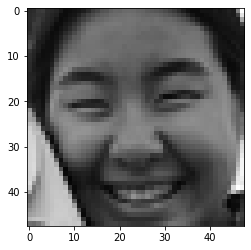

In [0]:
img = X_train[22323]
plt.imshow(img)

In [0]:
resized = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)

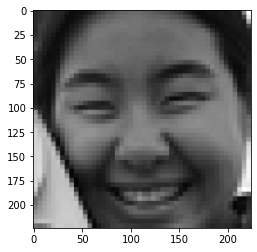

In [0]:
plt.imshow(resized)

In [0]:
resized = resized[np.newaxis,:,:,:]
preds = face_race_model.predict(resized)

In [0]:
race_labels = ['asian', 'indian', 'black', 'white', 'middle eastern', 'latino hispanic']
print(np.argmax(preds))

0
